<a href="https://colab.research.google.com/github/facundodelga/IA/blob/main/Sugeno1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install numpy


In [6]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')
%cd gdrive/MyDrive/IA 2023

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/MyDrive/IA 2023'
/content/gdrive/MyDrive/IA 2023


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random

In [8]:
def subtractive_clustering(data, Ra, Rb=0, AcceptRatio=0.3, RejectRatio=0.1):
    if Rb == 0:
        Rb = Ra * 1.15

    n_samples, n_features = data.shape
    centers = []  # Lista para almacenar los centros de los clústeres
    labels = np.zeros(n_samples, dtype=int)  # Etiquetas de clúster para cada punto

    # Escala los datos a un rango específico (por ejemplo, [0, 1])
    data_normalized = (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))

    # Calcula la matriz de distancias euclidianas
    dist_matrix = np.linalg.norm(data_normalized[:, np.newaxis, :] - data_normalized, axis=2)

    # Calcula P, la influencia de cada punto como centro
    alpha = (Ra / 2) ** 2
    P = np.sum(np.exp(-dist_matrix ** 2 / alpha), axis=0)

    # Encuentra el punto con la máxima influencia
    i_max = np.argmax(P)
    C = data_normalized[i_max]
    p = P[i_max]
    centers.append(C)

    # Inicia el proceso de sustracción iterativa
    continue_subtraction = True
    subtract_P = True

    while continue_subtraction:
        p_prev = p
        if subtract_P:
            P -= p * np.exp(-np.linalg.norm(data_normalized - C, axis=1) ** 2 / (Rb / 2) ** 2)
        subtract_P = True
        i_max = np.argmax(P)
        C = data_normalized[i_max]
        p = P[i_max]

        if p > AcceptRatio * p_prev:
            centers.append(C)
        elif p < RejectRatio * p_prev:
            continue_subtraction = False
        else:
            d_ratio = np.min([np.linalg.norm(C - c) for c in centers])
            if d_ratio / Ra + p / p_prev >= 1:
                centers.append(C)
            else:
                P[i_max] = 0
                subtract_P = False

        if not any(P > 0):
            continue_subtraction = False

    # Asigna etiquetas de clúster a cada punto
    for i, point in enumerate(data_normalized):
        distances_to_centers = [np.linalg.norm(point - center) for center in centers]
        labels[i] = np.argmin(distances_to_centers)

    # Convierte los centros de clúster de nuevo al rango original
    centers_original_range = centers * (np.max(data, axis=0) - np.min(data, axis=0)) + np.min(data, axis=0)

    return labels, centers_original_range


In [13]:
def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean)**2.) / (2 * sigma**2.))

class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma

class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids


    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        plt.figure()
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5
            y = gaussmf(x,m,s)
            plt.plot(x,y)

class fis:
    def __init__(self):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []
        self.mse = []

    def genfis(self, data, radii, numero_de_iteraciones):

        start_time = time.time()
        labels, cluster_center = subtractive_clustering(data, radii)

        print("--- %s seconds ---" % (time.time() - start_time))
        n_clusters = len(cluster_center)

        cluster_center = cluster_center[:,:-1]
        P = data[:,:-1]
        #T = data[:,-1]
        maxValue = np.max(P, axis=0)
        minValue = np.min(P, axis=0)

        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]

        self.rules = cluster_center
        for iteracion in range(numero_de_iteraciones):
          mse = self.entrenar(data)  # Llama a la función de entrenamiento
          self.mse.append(mse)  # Almacena el valor de MSE en la lista

    def entrenar(self, data):
        P = data[:,:-1]
        T = data[:,-1]
        #___________________________________________
        # MINIMOS CUADRADOS (lineal)
        sigma = np.array([(i.maxValue-i.minValue)/np.sqrt(8) for i in self.inputs])
        f = [np.prod(gaussmf(P,cluster,sigma),axis=1) for cluster in self.rules]

        nivel_acti = np.array(f).T
        #print("nivel acti")
        #print(nivel_acti)
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
        #print("sumMu")
        #print(sumMu)
        P = np.c_[P, np.ones(len(P))]
        n_vars = P.shape[1]

        orden = np.tile(np.arange(0,n_vars), len(self.rules))
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]


        A = acti*inp/sumMu

        # A = np.zeros((N, 2*n_clusters))
        # for jdx in range(n_clusters):
        #     for kdx in range(nVar):
        #         A[:, jdx+kdx] = nivel_acti[:,jdx]*P[:,kdx]/sumMu
        #         A[:, jdx+kdx+1] = nivel_acti[:,jdx]/sumMu

        b = T

        solutions, residuals, rank, s = np.linalg.lstsq(A,b,rcond=None)
        self.solutions = solutions #.reshape(n_clusters,n_vars)
        #print("Solutions")
        #print(solutions)

        mse = np.mean((np.dot(A, solutions) - b) ** 2)

        return mse

    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))

        P = np.c_[data, np.ones(len(data))]

        n_vars = P.shape[1]
        n_clusters = len(self.rules)

        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions

        return np.sum(acti*inp*coef/sumMu,axis=1)


    def viewInputs(self):
        for input in self.inputs:
            input.view()

    def mse(data):
      error = []
      for result in data:
          print()



137


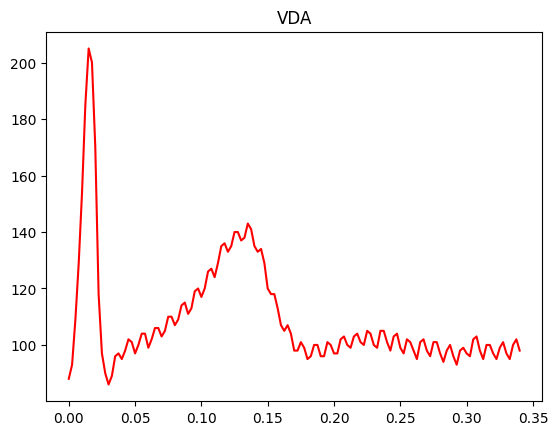

--- 0.00987553596496582 seconds ---


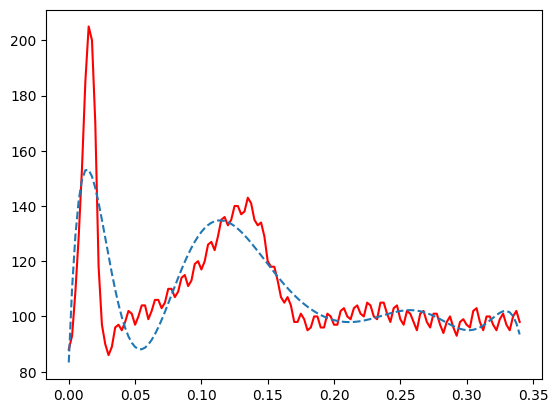

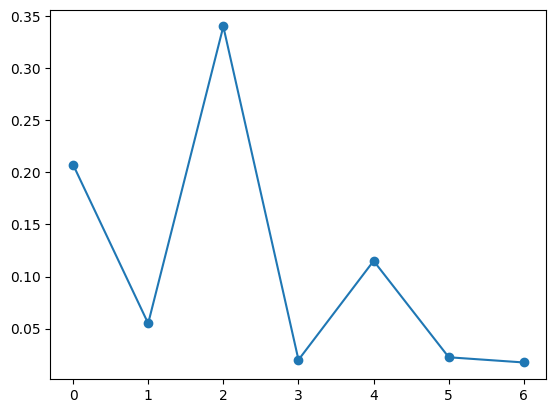

In [22]:
filename = "/content/gdrive/MyDrive/IA 2023/VDA/samplesVDA2.txt"
x_vda = []
x_tiempo = []
i = 0.0
with open(filename) as f:
  for lines in f:
    x_vda.append(int(lines))
    x_tiempo.append(0.0025 * i)
    i += 1

  x_vda = np.array(x_vda)
  x_tiempo = np.array(x_tiempo)

f.close()

plt.figure()
print(len(x_vda))
plt.plot(x_tiempo,x_vda,"r") #Gráfico de datos

plt.title("VDA")
plt.show()

data = np.vstack((x_tiempo, x_vda)).T
fis2 = fis()
fis2.genfis(data, 0.7,random.randrange(200)) #genero el modelo


r = fis2.evalfis(np.vstack(x_tiempo)) #Esto no se que significa

plt.figure()
plt.plot(x_tiempo,x_vda,"r")
plt.plot(x_tiempo,r,linestyle='--')

plt.figure()
plt.plot(fis2.rules, marker='o', linestyle='-') # Grafico las reglas???

#plt.figure()
#plt.plot(x_tiempo, fis2.mse, marker='o', linestyle='-')
#plt.title('Evolución del MSE durante el entrenamiento')



# Nueva sección